# Project Overview
This notebook presents the development of a modified ResNet architecture aimed at achieving high classification accuracy on the CIFAR-10 dataset, with the constraint of maintaining fewer than 5 million parameters. The project explores various architectural, optimization, and data processing strategies to meet these objectives.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Send data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:06<00:00, 27962438.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Adjust this to match parameter budget

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Adjust block numbers to fit parameter budget
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)

        # Removed layer4 to save parameters and fit the budget

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Ensure the linear layer matches the output of layer3
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Removed the pass through the removed layer4

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNetCustom():
    return ResNet(BasicBlock, [2, 2, 3])  # Adjusted block numbers for the budget

model = ResNetCustom().to(device)


In [5]:
model = ResNetCustom().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [6]:
# Calculate and print the number of trainable parameters in the model
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters: {model_parameters}")

Number of Trainable Parameters: 3958346


In [7]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train(epoch):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%')

def validate(epoch):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')


In [8]:
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
lr_changes = []

for epoch in range(epochs):
    train(epoch)
    validate(epoch)
    scheduler.step()
    lr_changes.append(optimizer.param_groups[0]['lr'])

model_save_path = './model_weights.pth'  # Saves the file in the current directory
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Train Loss: 1.3919, Train Acc: 48.70%
Epoch: 0, Val Loss: 1.3598, Val Acc: 56.39%
Epoch: 1, Train Loss: 0.9300, Train Acc: 67.02%
Epoch: 1, Val Loss: 0.8965, Val Acc: 68.04%
Epoch: 2, Train Loss: 0.7300, Train Acc: 74.22%
Epoch: 2, Val Loss: 0.7456, Val Acc: 73.97%
Epoch: 3, Train Loss: 0.6244, Train Acc: 78.23%
Epoch: 3, Val Loss: 0.7213, Val Acc: 75.62%
Epoch: 4, Train Loss: 0.5490, Train Acc: 80.94%
Epoch: 4, Val Loss: 0.6899, Val Acc: 77.47%
Epoch: 5, Train Loss: 0.4971, Train Acc: 82.97%
Epoch: 5, Val Loss: 0.7078, Val Acc: 78.05%
Epoch: 6, Train Loss: 0.4534, Train Acc: 84.47%
Epoch: 6, Val Loss: 0.6601, Val Acc: 79.85%
Epoch: 7, Train Loss: 0.4206, Train Acc: 85.59%
Epoch: 7, Val Loss: 0.5920, Val Acc: 81.19%
Epoch: 8, Train Loss: 0.3965, Train Acc: 86.49%
Epoch: 8, Val Loss: 0.5868, Val Acc: 80.16%
Epoch: 9, Train Loss: 0.3711, Train Acc: 87.34%
Epoch: 9, Val Loss: 0.5626, Val Acc: 81.99%
Epoch: 10, Train Loss: 0.2476, Train Acc: 91.66%
Epoch: 10, Val Loss: 0.3051, Va

In [9]:
test_accuracy = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")


Final Test Accuracy: 91.01%


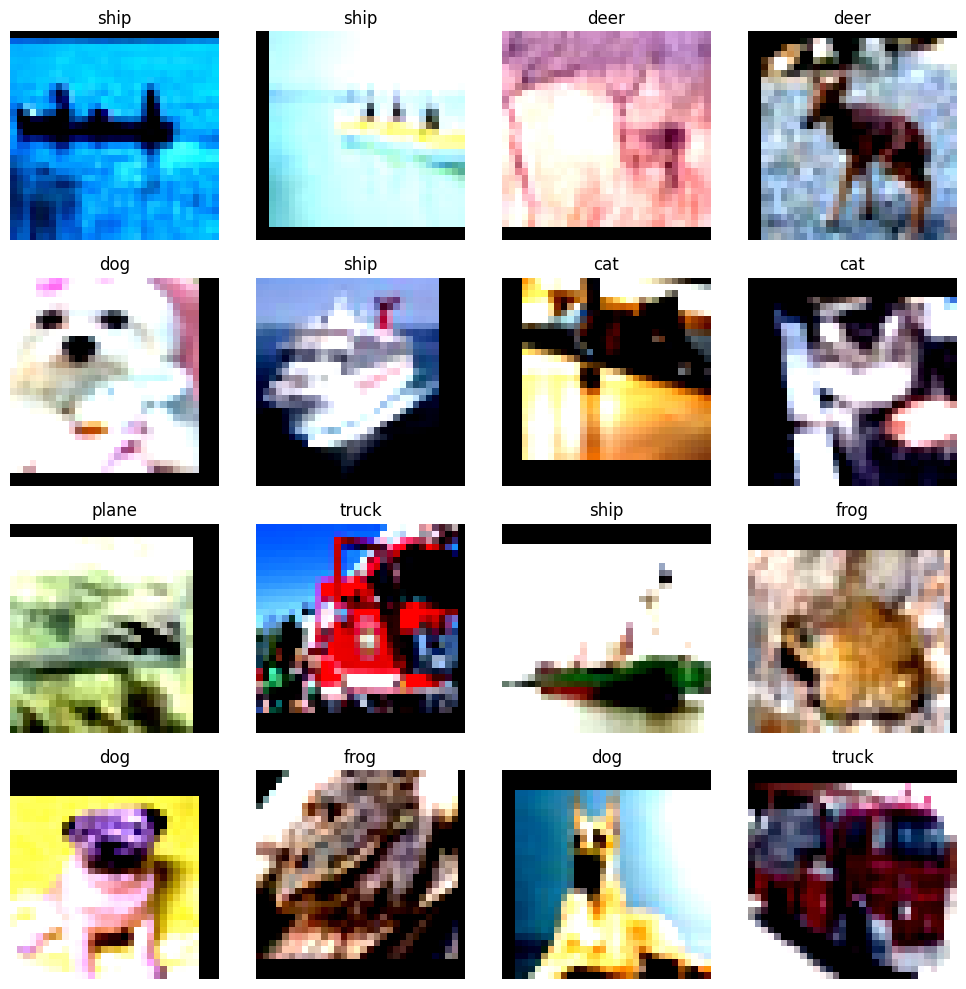

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and show an image
def imshow(img):
    # these are the standard mean and std values used during training for CIFAR10
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] to avoid warning
    plt.imshow(img)
    plt.axis('off')

# Assuming train_loader has been defined and loaded with CIFAR-10 data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the classes for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Setup the number of images you want to display
num_images = 16
rows = 4
cols = 4

# Create a figure to plot the images
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
axs = axs.ravel()

for i in range(num_images):
    axs[i].imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


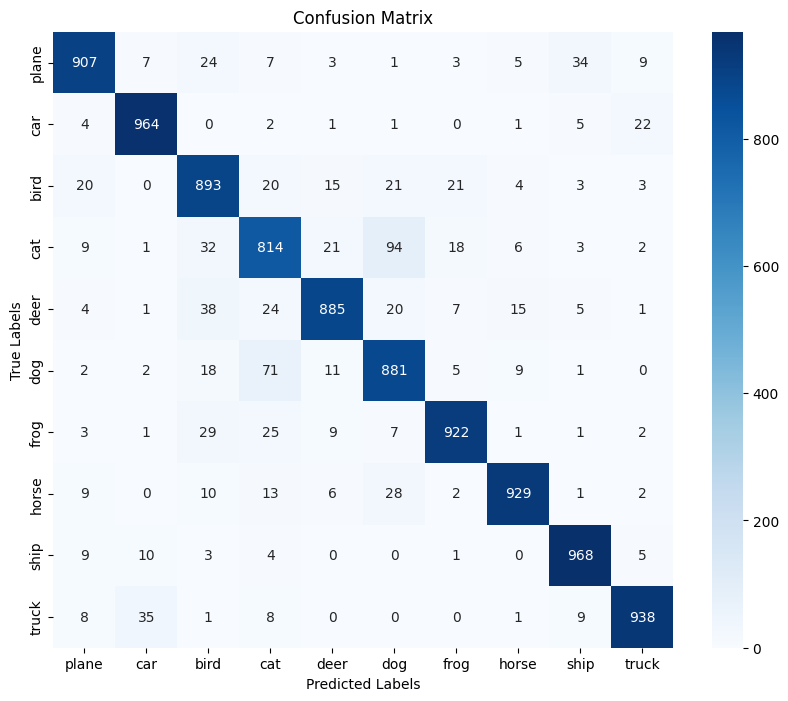

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions for the test dataset
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
lr_changes = []

for epoch in range(epochs):
    train(epoch)  # Your training function
    validate(epoch)  # Your validation function
    scheduler.step()  # Adjust learning rate
    lr_changes.append(optimizer.param_groups[0]['lr'])

# Plotting the learning rate schedule
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), lr_changes, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Train Loss: 0.1037, Train Acc: 96.59%
Epoch: 0, Val Loss: 0.2806, Val Acc: 91.61%
Epoch: 1, Train Loss: 0.0988, Train Acc: 96.73%
Epoch: 1, Val Loss: 0.2815, Val Acc: 91.59%
Epoch: 2, Train Loss: 0.0945, Train Acc: 96.92%
Epoch: 2, Val Loss: 0.2843, Val Acc: 91.56%
Epoch: 3, Train Loss: 0.0954, Train Acc: 96.79%
Epoch: 3, Val Loss: 0.2817, Val Acc: 91.63%
Epoch: 4, Train Loss: 0.0897, Train Acc: 97.00%
Epoch: 4, Val Loss: 0.2846, Val Acc: 91.59%
Epoch: 5, Train Loss: 0.0924, Train Acc: 97.02%


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
